# FullSpec Bayesian Outlier Model

Use a vectorized approach instead of sharing hyper-parameters between an observed and unobserved random variate

# Inputs

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest

In [5]:
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt_centered.hd5')
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal']
tumor = df[df.label == 'tcga-tumor']

In [8]:
df.head()

,id,tissue,subtype,tumor,label,RP11-40C6.2,IGHG1,IGKC,KRT5,IGLC2,...,IGHEP1,RP11-44N21.4,GAPDHP61,P2RX5-TAX1BP3,RP11-408H20.3,RP13-726E6.2,CTB-43E15.1,ZNF878,OR2H2,RP4-530I15.9
GTEX-UTHO-1226-SM-3GAEE,GTEX-UTHO-1226-SM-3GAEE,Heart,Heart_Atrial_Appendage,no,gtex,-1.211260,0.905252,0.674399,-0.175369,0.388792,...,-0.261452,-0.391506,-0.309631,-0.740657,-0.401758,-0.681096,-0.356918,-0.719266,2.029397,1.837806
GTEX-146FH-1726-SM-5QGQ2,GTEX-146FH-1726-SM-5QGQ2,Esophagus,Esophagus_Mucosa,no,gtex,-0.502883,0.539459,0.610233,2.222542,0.554726,...,0.303442,-0.391506,-0.309631,0.095169,-0.401758,-0.116008,-0.356918,1.052202,-0.370071,0.435850
GTEX-QDT8-0126-SM-48TZ1,GTEX-QDT8-0126-SM-48TZ1,Skin,Skin_Sun_Exposed_(Lower_leg),no,gtex,-0.557445,-0.825342,-0.894589,1.765345,-0.561263,...,-0.261452,-0.391506,0.172743,-0.699182,5.255706,-0.681096,0.891968,-0.420741,1.016892,1.067122
GTEX-QCQG-1326-SM-48U24,GTEX-QCQG-1326-SM-48U24,Uterus,Uterus,no,gtex,-1.211260,-0.604086,-0.835154,-0.446600,-0.979139,...,-0.261452,-0.391506,0.214217,0.332293,-0.401758,0.387489,-0.356918,0.578169,1.275865,1.067122
GTEX-WZTO-2926-SM-3NM9I,GTEX-WZTO-2926-SM-3NM9I,Brain,Brain_Cortex,no,gtex,-1.211260,-1.231433,-1.273151,-0.184560,-1.195402,...,-0.261452,-0.391506,-0.128336,2.117556,0.739453,-0.034883,-0.356918,-0.944930,1.050123,-0.379422


In [3]:
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]
len(drug_genes)

85

# Model One Gene

As a test, build a linear model for one gene that uses all the background datasets

In [5]:
tumor_id = 'TCGA-KK-A7B2-01'
n_of_1 = tumor.loc[tumor_id]

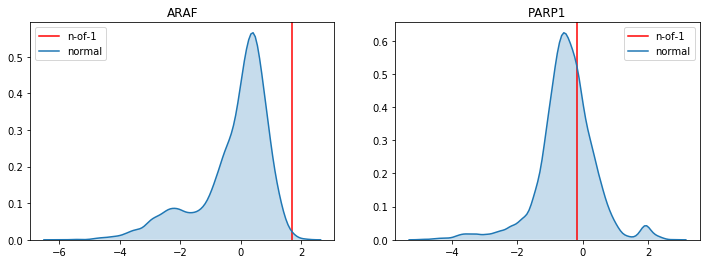

In [46]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, gene in enumerate(['ARAF', 'PARP1']):
    ax[i].axvline(n_of_1[gene], label='n-of-1', c='r')
    sns.kdeplot(gtex[gene], label='normal', shade=True, ax=ax[i])
    ax[i].set_title(gene)

In [13]:
idx = gtex.tissue.astype('category').cat.codes
n_cats = len(gtex.tissue.unique())

In [6]:
with pm.Model() as m1:
    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=0, sd=100)
    sigma_a = pm.InverseGamma('sigma_a', 2.1, 1)
    mu_b = pm.Normal('mu_b', mu=0, sd=100)
    sigma_b = pm.InverseGamma('sigma_b', 2.1, 1)
    
    # A and B parameters
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_cats)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_cats)
    
    araf = a[idx] + b[idx] * gtex.ARAF
    
    # Model estimation
    eps = pm.InverseGamma('eps', 2.1, 1)
    araf_like = pm.Normal('araf_like', mu=araf, sd=eps, observed=n_of_1.ARAF)

In [19]:
with m1:
    t1 = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains: 100%|██████████| 6000/6000 [09:50<00:00, 12.28draws/s]  


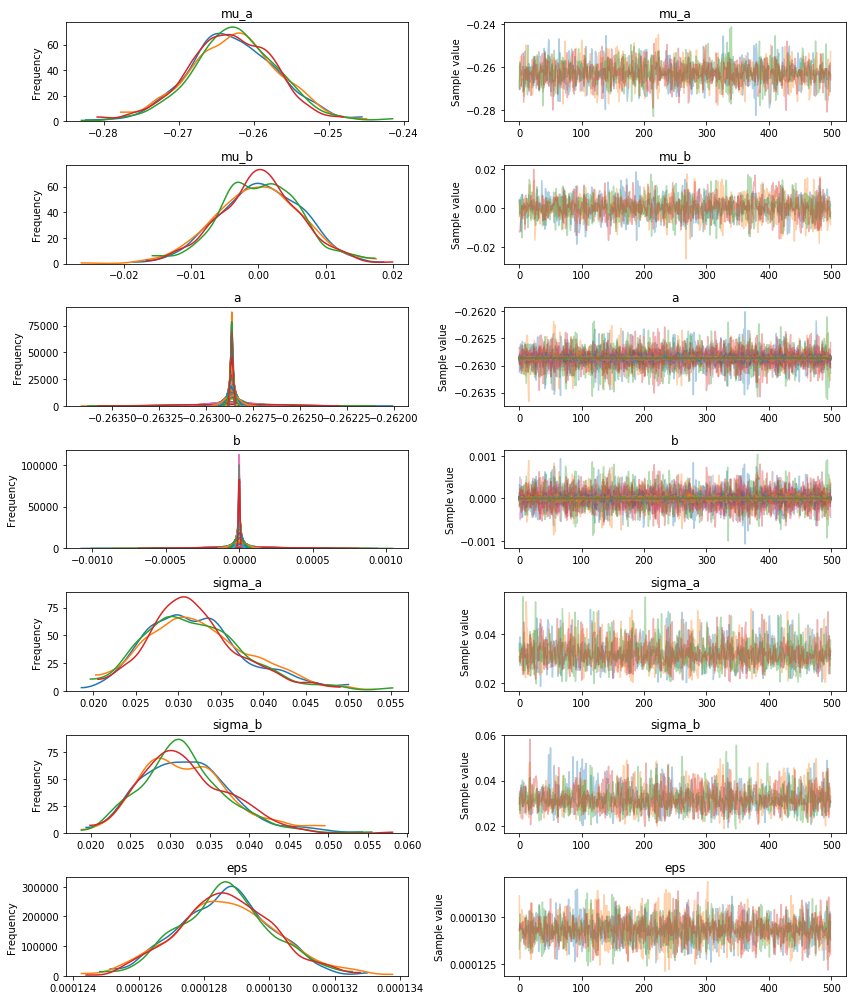

In [20]:
pm.traceplot(t1);

In [21]:
p1 = pm.sample_ppc(trace=t1, model=m1)

100%|██████████| 500/500 [00:01<00:00, 363.72it/s]


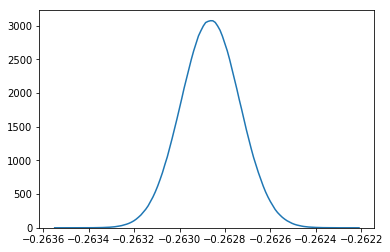

In [22]:
sns.kdeplot(p1['araf_like'].ravel())

# Model Two Genes

In [27]:
n_of_1.PARP1

0.297314

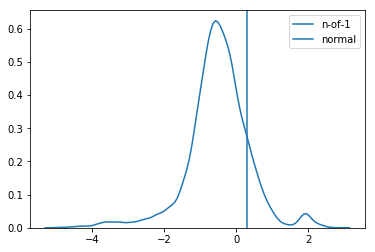

In [23]:
plt.axvline(n_of_1.PARP1, label='n-of-1')
sns.kdeplot(gtex.PARP1, label='normal');

In [24]:
with pm.Model() as m2:
    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=0, sd=100)
    sigma_a = pm.InverseGamma('sigma_a', 2.1, 1)
    mu_b = pm.Normal('mu_b', mu=0, sd=100)
    sigma_b = pm.InverseGamma('sigma_b', 2.1, 1)
    
    # A and B parameters
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_cats)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_cats)
    
    araf = a[idx] + b[idx] * gtex.ARAF
    parp1 = a[idx] + b[idx] * gtex.PARP1
    
    # Model estimation
    eps = pm.InverseGamma('eps', 2.1, 1)
    araf_like = pm.Normal('araf_like', mu=araf, sd=eps, observed=n_of_1.ARAF)
    parp1_like = pm.Normal('parp1_like', mu=parp1, sd=eps, observed=n_of_1.PARP1)

In [25]:
with m2:
    t2 = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains: 100%|██████████| 6000/6000 [04:16<00:00, 13.33draws/s]


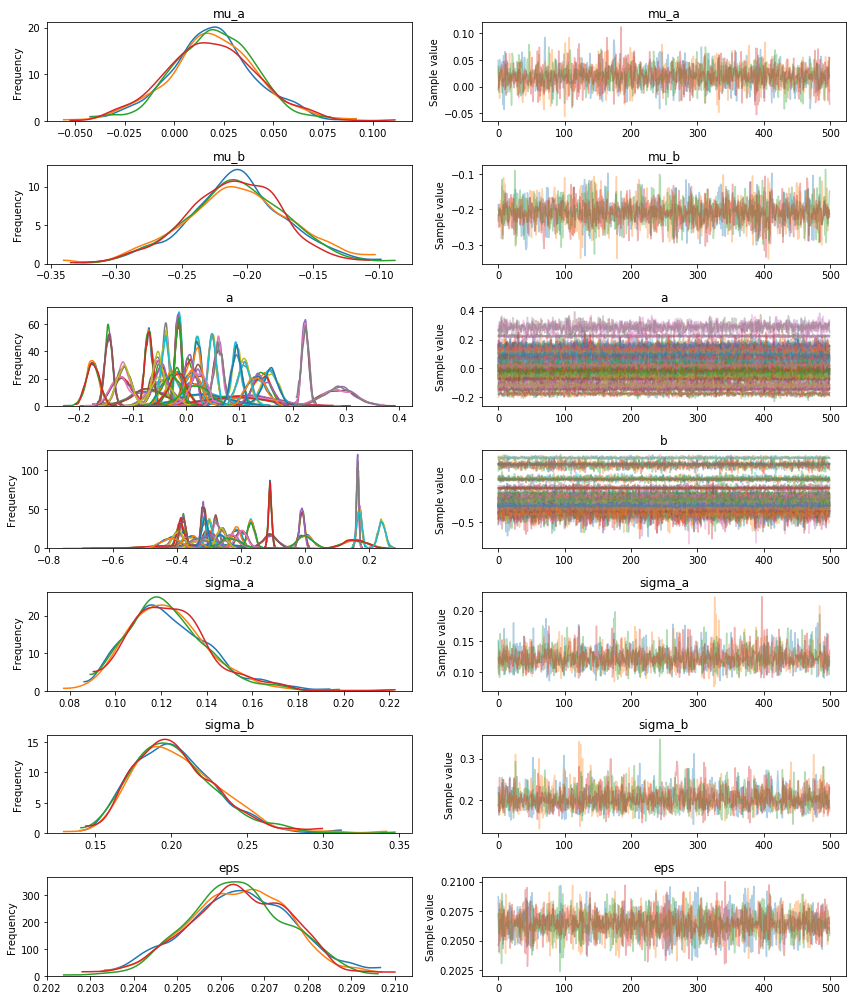

In [26]:
pm.traceplot(t2);

In [17]:
p2 = pm.sample_ppc(trace=t2, model=m2)

100%|██████████| 500/500 [00:02<00:00, 173.38it/s]


# N Genes

In [28]:
def vector_model(genes, background_df, class_col):   
    
    idx = background_df[class_col].astype('category').cat.codes
    n_cats = len(background_df[class_col].unique())
    
    with pm.Model() as model:
        # Hyperpriors
        mu_a = pm.Normal('mu_a', mu=0, sd=100)
        sigma_a = pm.InverseGamma('sigma_a', 2.1, 1)
        mu_b = pm.Normal('mu_b', mu=0, sd=100)
        sigma_b = pm.InverseGamma('sigma_b', 2.1, 1)

        # Alpha and Beta parameters
        a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_cats)
        b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_cats)
        
        # Linear model
        mu = {}
        for gene in genes:
            mu[gene] = a[idx] + b[idx] * background_df[gene]
        
        # Model estimation
        eps = pm.InverseGamma('eps', 2.1, 1)
        z = {}
        for gene in genes:
            z = pm.Normal(gene, mu=mu[gene], sd=eps, observed=n_of_1[gene])
    
        trace = pm.sample(tune=1000)
        return model, trace

## 50 Genes

- Pick 50 informative genes via SelectKBest
- Run against 31 background distributions in GTEx

In [ ]:
genes = df.columns[5:]
k = SelectKBest(k=50)
k.fit_transform(gtex[genes], gtex['tissue'])
training_genes = [genes[i] for i in k.get_support(indices=True)]

In [40]:
model, trace = vector_model(training_genes, gtex, 'tissue')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains: 100%|██████████| 6000/6000 [2:00:38<00:00,  1.67s/draws]  


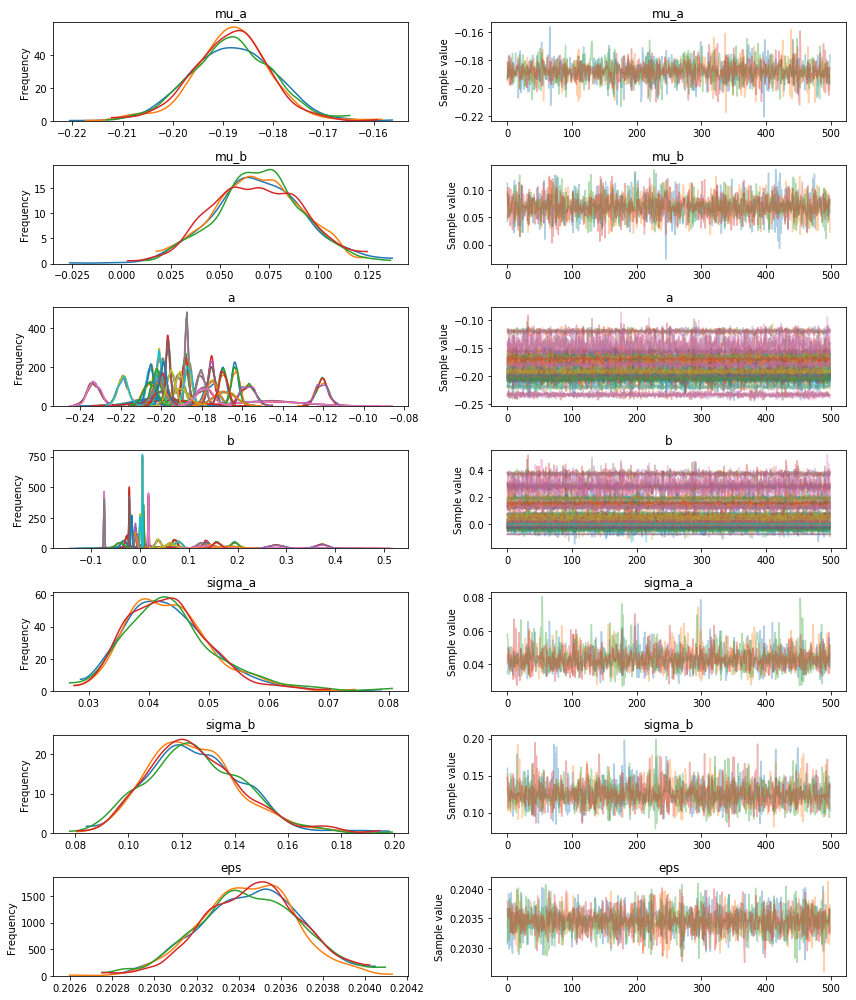

In [42]:
pm.traceplot(trace);

## Single Alpha

In [11]:
def vector_model_a(genes, background_df, class_col):   
    
    idx = background_df[class_col].astype('category').cat.codes
    n_cats = len(background_df[class_col].unique())
    
    with pm.Model() as model:
        # Hyperpriors
        mu_a = pm.Normal('mu_a', mu=0, sd=100)
        sigma_a = pm.InverseGamma('sigma_a', 2.1, 1)
        mu_b = pm.Normal('mu_b', mu=0, sd=100)
        sigma_b = pm.InverseGamma('sigma_b', 2.1, 1)

        # Alpha and Beta parameters
        a = pm.Normal('a', mu=mu_a, sd=sigma_a)#, shape=n_cats)
        b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_cats)
        
        # Linear model
        mu = {}
        for gene in genes:
            mu[gene] = a + b[idx] * background_df[gene]
        
        # Model estimation
        eps = pm.InverseGamma('eps', 2.1, 1)
        z = {}
        for gene in genes:
            z = pm.Laplace(gene, mu=mu[gene], b=eps, observed=n_of_1[gene])
    
        trace = pm.sample(tune=1000)
        return model, trace

In [ ]:
m_a, t_a = vector_model_a(training_genes, gtex, 'tissue')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains:  18%|█▊        | 1104/6000 [1:07:34<26:18:00, 19.34s/draws]

## No Hyperpriors for Alpha

In [16]:
def vector_model_b(sample, genes, background_df, class_col):   
    
    # Build index tied to background distribution categories
    idx = background_df[class_col].astype('category').cat.codes
    n_cats = len(background_df[class_col].unique())
    
    with pm.Model() as model:
        # Hyperpriors
        #mu_a = pm.Normal('mu_a', mu=0, sd=100)
        #sigma_a = pm.InverseGamma('sigma_a', 2.1, 1)
        mu_b = pm.Normal('mu_b', mu=0, sd=10)
        sigma_b = pm.InverseGamma('sigma_b', 2.1, 1)

        # Alpha and Beta parameters
        a = pm.Normal('a', mu=0, sd=10)
        b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_cats)
        
        # Linear model
        mu = {}
        for gene in genes:
            mu[gene] = a + b[idx] * background_df[gene]
        
        # Model estimation
        eps = pm.InverseGamma('eps', 2.1, 1)
        z = {}
        for gene in genes:
            z = pm.Laplace(gene, mu=mu[gene], b=eps, observed=sample[gene])
    
        trace = pm.sample(tune=1000)
        return model, trace

In [17]:
m_b, t_b = vector_model_b(drug_genes, gtex, 'tissue')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b]
Sampling 4 chains: 100%|██████████| 6000/6000 [2:18:42<00:00,  1.05draws/s]  


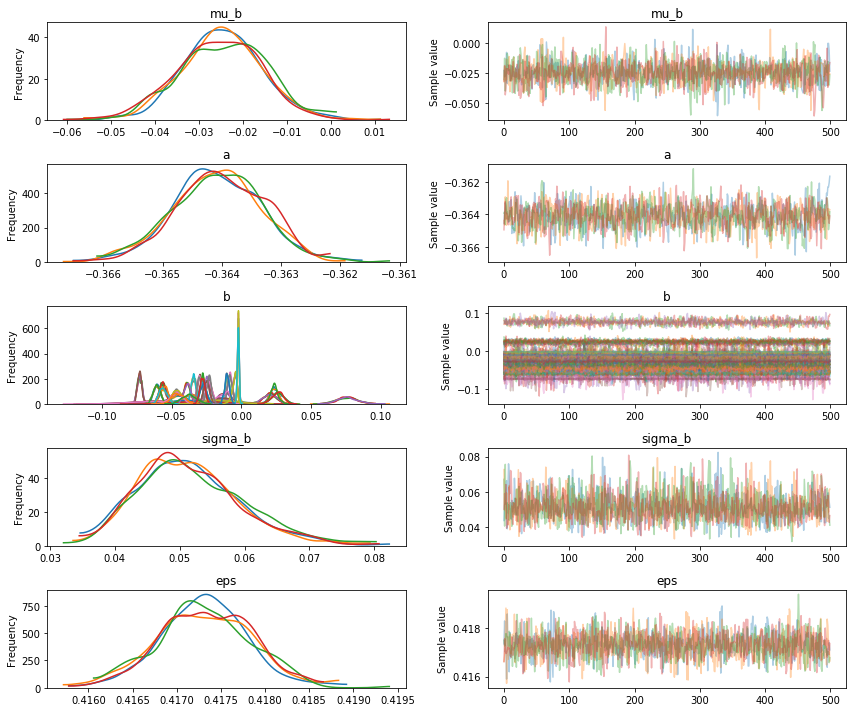

In [20]:
pm.traceplot(t_b);

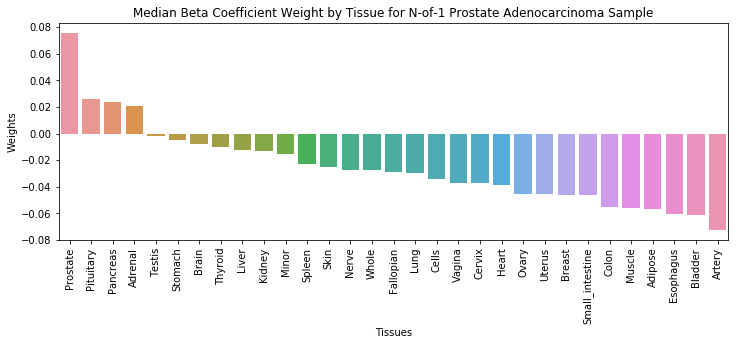

In [45]:
tissues = sorted(gtex.tissue.unique())
weight_by_tissue = pd.DataFrame({'Tissues': tissues,
                                 'Weights': [np.median(t_b['b'][:,x]) 
                                             for x in range(len(tissues))]})
weight_by_tissue = weight_by_tissue.sort_values('Weights', ascending=False)

plt.figure(figsize=(12, 4))
sns.barplot(data=weight_by_tissue, x='Tissues', y='Weights')
plt.xticks(rotation=90)
plt.title('Median Beta Coefficient Weight by Tissue for N-of-1 Prostate Adenocarcinoma Sample');

In [21]:
ppc = pm.sample_ppc(trace=t_b, model=m_b)

100%|██████████| 500/500 [02:02<00:00,  4.78it/s]


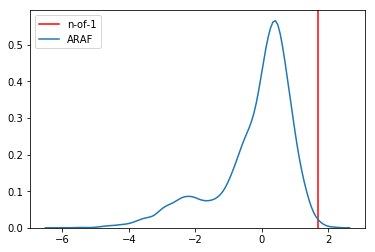

In [25]:
plt.axvline(n_of_1['ARAF'], c='r', label='n-of-1')
sns.kdeplot(gtex['ARAF'])

In [47]:
n_of_1['ARAF']

1.6916137

In [62]:
def ppp(sample, gene, ppc):
    z_true = sample[gene]
    z = ppc[gene].ravel()
    return round(sum(z_true < z) / len(z), 5)

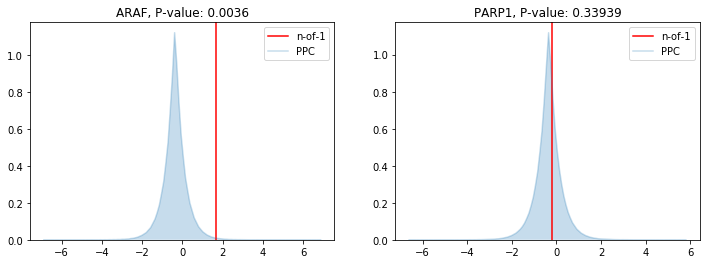

In [63]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, gene in enumerate(['ARAF', 'PARP1']):
    ax[i].axvline(n_of_1[gene], c='r', label='n-of-1')
    sns.kdeplot(ppc[gene].ravel(), label='PPC', shade=True, alpha=0.25, ax=ax[i])
    p_val = ppp(n_of_1, gene, ppc)
    ax[i].set_title(f'{gene}, P-value: {p_val}')

Training genes

In [ ]:
m_c, t_c = vector_model_b(training_genes, gtex, 'tissue')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b]
Sampling 4 chains:  20%|█▉        | 1184/6000 [59:01<25:04:50, 18.75s/draws]

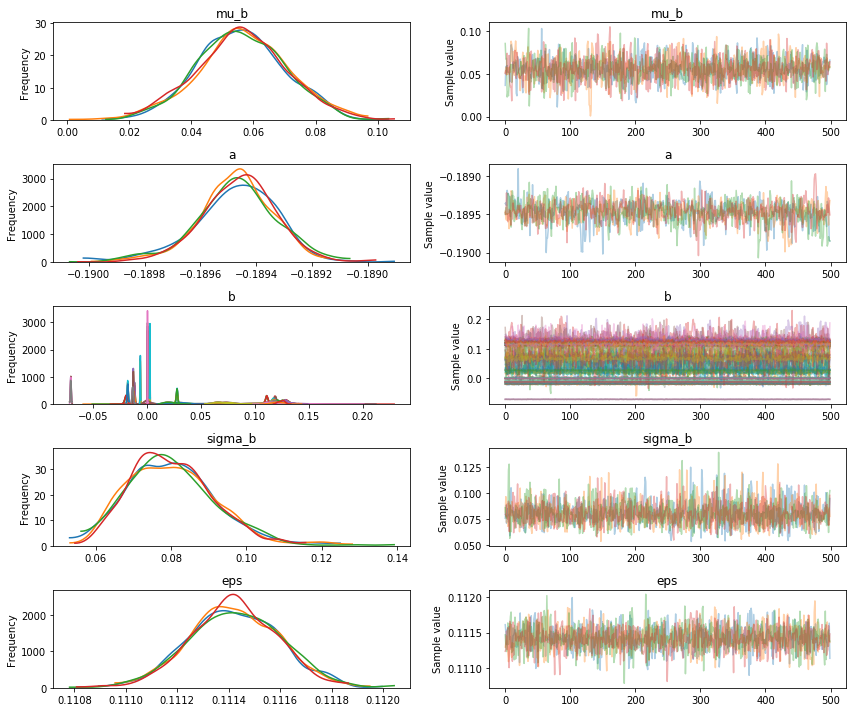

In [32]:
pm.traceplot(t_c);

## Normal instead of Laplace for Z